### Mock Experiment 02

Design:
- 1 region
- 1 tile
- 2 channels
- 2 cycles
    - cycle 1: dapi + pha
    - cycle 2: dapi (misaligned) + binary cell segmentation
- 3 z planes

Tests:
    - Verify drift compensation between cycles
    - Verify segmentation to validated segmentation (stored separately)
    - Verify quantification through mean signal in cycle 2, channel
    
Data Exported:
    - Nucleus and cell segmentation masks

In [1]:
%matplotlib inline
import numpy as np
import os
import os.path as osp
import cytokit
from cytokit import config as ck_config
from cytokit import io as ck_io
from cytokit.function import data as ck_fn
import matplotlib.pyplot as plt
from cytokit.image.visualize import display_images
from skimage import transform 
from centrosome import cpmorphology
from matplotlib.colors import ListedColormap

## Load Real Data

In [2]:
exp_dir = '/lab/data/cytokit/cellular-marker/'
exp_name = '20181116-d40-r1-20x-5by5'
output_dir = osp.join(exp_dir, exp_name, 'output', 'v00')

In [3]:
ireg, tx, ty = 0, 0, 0
config = ck_config.load(osp.join(output_dir, 'config'))

z = ck_fn.get_best_focus_coord_map(output_dir)[(ireg, tx, ty)]

img_path = osp.join(output_dir, ck_io.get_processor_img_path(ireg, tx, ty))
tile, tile_meta = ck_io.read_tile(img_path, return_metadata=True)

img_path = osp.join(output_dir, ck_io.get_extract_image_path(ireg, tx, ty, 'best_z_segm'))
ext, ext_meta = ck_io.read_tile(img_path, return_metadata=True)

tile.shape, ext.shape, z

((1, 25, 4, 1008, 1344), (1, 1, 6, 1008, 1344), 13)

In [4]:
# Specify subsets/slices to extract for synthetic tile generation
rs, cs = 300, 300
win2d = slice(rs, rs + 128), slice(cs, cs + 128)
win3d = (slice(None),) + win2d
zs = [z-3, z, z+3]

In [5]:
ext_meta['labels']

['cyto_cell_boundary',
 'cyto_nucleus_boundary',
 'proc_CD4',
 'proc_CD8',
 'proc_DAPI',
 'proc_PHA']

In [6]:
# Extract dapi + pha channel images (at full size and for several z planes)
icyc, ich = config.get_channel_coordinates('DAPI')
img_nuc = tile[icyc, zs, ich]

icyc, ich = config.get_channel_coordinates('PHA')
img_memb = tile[icyc, zs, ich]

In [7]:
img_nuc.shape

(3, 1008, 1344)

In [8]:
# Extract segmentation masks (also at full size but only for one z plane)
np.random.seed(8)
cmap = ListedColormap(np.random.rand(256, 3))

def fill_holes(img):
    return cpmorphology.fill_labeled_holes(img)

img_seg_cell = fill_holes(ext[0, 0, ext_meta['labels'].index('cyto_cell_boundary')])
img_seg_nuc = fill_holes(ext[0, 0, ext_meta['labels'].index('cyto_nucleus_boundary')])

In [9]:
img_nuc[win3d].shape

(3, 128, 128)

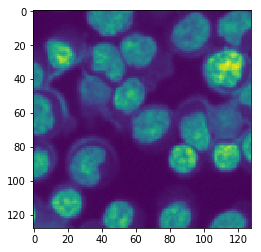

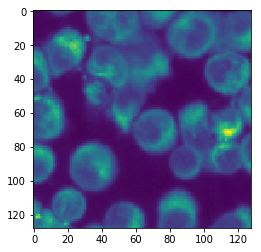

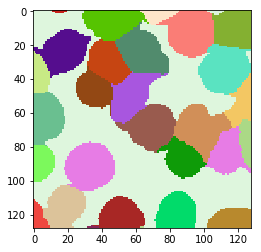

In [10]:
plt.imshow(img_nuc[win3d][1]) # Middle z
plt.figure()
plt.imshow(img_memb[win3d][1]) # Middle z
plt.figure()
plt.imshow(img_seg_cell[win2d], cmap=cmap)

## Synthetic Transformations

In [11]:
cyc2_trans = (-3, 12) # cols, rows
def translate(img, trans):
    atrans = transform.AffineTransform(translation=trans)
    if img.ndim == 2:
        return transform.warp(img, atrans, preserve_range=True).astype(img.dtype)
    elif img.ndim == 3:
        return np.stack([
            transform.warp(img[i], atrans, preserve_range=True).astype(img.dtype)
            for i in range(img.shape[0])        
        ], axis=0)
    else:
        raise ValueError('Image shape {} invalid'.format(img.shape))


In [12]:
# Generate synthetic tile with translations

cyc1 = np.stack([img_nuc[win3d], img_memb[win3d]], axis=1)
cyc2 = np.stack([
    translate(img_nuc, cyc2_trans)[win3d],
    # Convert labeled segmentation image to binary uint8 (w/ 255 max), apply translation, 
    # take 2D crop, and repeat in z dimension to match other images
    np.repeat(
        translate(
            ((img_seg_cell > 0)*255).astype(np.uint8), 
            cyc2_trans
        )[win2d][np.newaxis], 
        len(zs), 
        axis=0
    )
], axis=1)
assert cyc1.shape == cyc2.shape
tile_exp = np.stack([cyc1, cyc2], 0)
tile_exp.shape

(2, 3, 2, 128, 128)

In [13]:
def display_channel(ich, name):
    return display_images(
        images = [ 
            tile_exp[icyc, iz, ich]
            for icyc in range(tile_exp.shape[0]) 
            for iz in range(tile_exp.shape[1])
        ]
        , titles = [ 
            'CH:{} - CYC{} - Z{}'.format(name, icyc, iz)
            for icyc in range(tile_exp.shape[0]) 
            for iz in range(tile_exp.shape[1])
        ],
        cols=tile_exp.shape[1]
    )

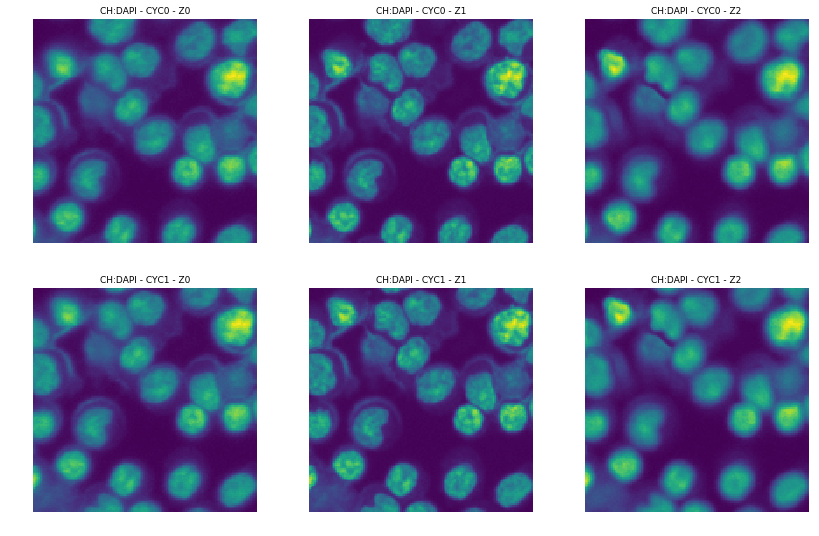

In [14]:
display_channel(0, 'DAPI')

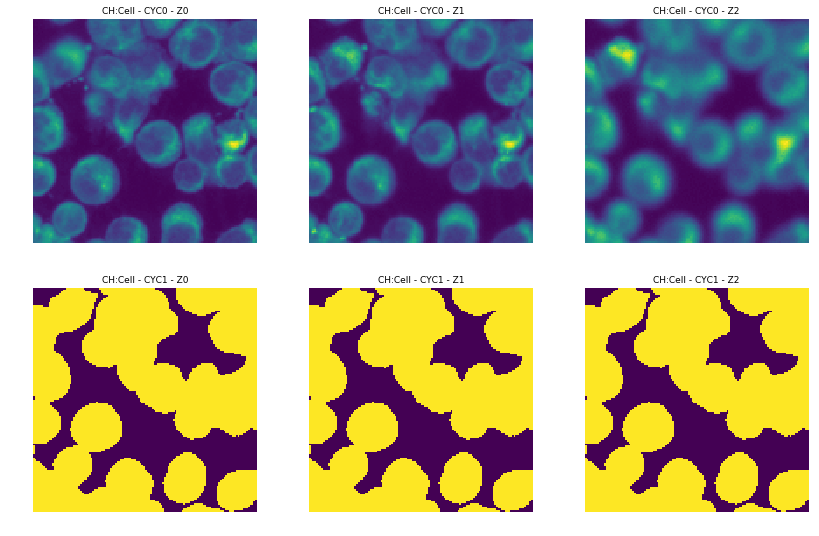

In [15]:
display_channel(1, 'Cell')

## Export

In [16]:
exp_dir = '/lab/repos/cytokit/python/pipeline/tests/data/experiment/cellular-marker-small'
sim_dir = osp.join(exp_dir, 'raw')
if not osp.exists(sim_dir):
    os.makedirs(sim_dir)
sim_dir

'/lab/repos/cytokit/python/pipeline/tests/data/experiment/cellular-marker-small/raw'

In [17]:
ncyc, nz, nch, nr, nc = tile_exp.shape
(ncyc, nz, nch, nr, nc)

(2, 3, 2, 128, 128)

In [18]:
from skimage import io as sk_io
paths = []
for icyc in range(ncyc):
    for iz in range(nz):
        for ich in range(nch):
            img_path = osp.join(sim_dir, ck_io.get_raw_img_path(ireg=0, itile=0, icyc=icyc, ich=ich, iz=iz))
            if not osp.exists(osp.dirname(img_path)):
                os.makedirs(osp.dirname(img_path))
            paths.append(img_path)
            print('Saving 2D grayscale image to:', img_path)
            sk_io.imsave(img_path, tile_exp[icyc, iz, ich])

Saving 2D grayscale image to: /lab/repos/cytokit/python/pipeline/tests/data/experiment/cellular-marker-small/raw/Cyc1_reg1/1_00001_Z001_CH1.tif
Saving 2D grayscale image to: /lab/repos/cytokit/python/pipeline/tests/data/experiment/cellular-marker-small/raw/Cyc1_reg1/1_00001_Z001_CH2.tif
Saving 2D grayscale image to: /lab/repos/cytokit/python/pipeline/tests/data/experiment/cellular-marker-small/raw/Cyc1_reg1/1_00001_Z002_CH1.tif
Saving 2D grayscale image to: /lab/repos/cytokit/python/pipeline/tests/data/experiment/cellular-marker-small/raw/Cyc1_reg1/1_00001_Z002_CH2.tif
Saving 2D grayscale image to: /lab/repos/cytokit/python/pipeline/tests/data/experiment/cellular-marker-small/raw/Cyc1_reg1/1_00001_Z003_CH1.tif
Saving 2D grayscale image to: /lab/repos/cytokit/python/pipeline/tests/data/experiment/cellular-marker-small/raw/Cyc1_reg1/1_00001_Z003_CH2.tif
Saving 2D grayscale image to: /lab/repos/cytokit/python/pipeline/tests/data/experiment/cellular-marker-small/raw/Cyc2_reg1/1_00001_Z001_

In [19]:
img_test = sk_io.imread(paths[0])
assert img_test.ndim == 2
assert img_test.dtype == np.uint8

img_test = sk_io.imread(paths[-1])
assert img_test.ndim == 2
assert img_test.dtype == np.uint8

In [20]:
# Save ground-truth labeled nuclei and cell images separately (as uint16)

val_dir = osp.join(exp_dir, 'validation')
if not osp.exists(val_dir):
    os.makedirs(val_dir)

img_path = osp.join(val_dir, 'cells.tif')
sk_io.imsave(img_path, img_seg_cell[win2d])
print('Saved cell masks to:', img_path)

img_path = osp.join(val_dir, 'nuclei.tif')
sk_io.imsave(img_path, img_seg_nuc[win2d])
print('Saved nuclei masks to:', img_path)

Saved cell masks to: /lab/repos/cytokit/python/pipeline/tests/data/experiment/cellular-marker-small/validation/cells.tif
Saved nuclei masks to: /lab/repos/cytokit/python/pipeline/tests/data/experiment/cellular-marker-small/validation/nuclei.tif


/usr/local/lib/python3.5/dist-packages/skimage/io/_io.py:140: UserWarning: /lab/repos/cytokit/python/pipeline/tests/data/experiment/cellular-marker-small/validation/cells.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/usr/local/lib/python3.5/dist-packages/skimage/io/_io.py:140: UserWarning: /lab/repos/cytokit/python/pipeline/tests/data/experiment/cellular-marker-small/validation/nuclei.tif is a low contrast image
  warn('%s is a low contrast image' % fname)


## Test Processing

In [21]:
import cytokit
from cytokit.cli import processor, analysis, operator
import tempfile

out_dir = tempfile.mkdtemp(prefix='cytokit_pipeline_test_')
raw_dir = osp.join(cytokit.test_data_dir, 'experiment', 'cellular-marker-small', 'raw')
val_dir = osp.join(cytokit.test_data_dir, 'experiment', 'cellular-marker-small', 'validation')
config_dir = osp.join(cytokit.test_data_dir, 'experiment', 'cellular-marker-small', 'config')

config = ck_config.load(config_dir)
processor.Processor(data_dir=raw_dir, config_path=config_dir).run_all(output_dir=out_dir, run_drift_comp=False, run_deconvolution=True)
operator.Operator(data_dir=out_dir, config_path=config_dir).run_all()
analysis.Analysis(data_dir=out_dir, config_path=config_dir).run_all()

2018-12-16 20:21:54,651:INFO:12766:root: Execution arguments and environment saved to "/tmp/cytokit_pipeline_test_dcz3wrwg/processor/execution/201812162021.json"
2018-12-16 20:21:56,284:INFO:12766:cytokit.exec.pipeline: Starting Pre-processing pipeline for 2 tasks (2 workers)
2018-12-16 20:22:11,812:INFO:12766:root: Pre-processing complete; Measurement data saved to "/tmp/cytokit_pipeline_test_dcz3wrwg/processor/data.json"
2018-12-16 20:22:11,813:INFO:12766:cytokit.exec.pipeline: Pipeline execution completed in 17 seconds
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP local=tcp://172.17.0.2:54504 remote=tcp://172.17.0.2:34587>
2018-12-16 20:22:11,851:INFO:12766:root: Creating extraction "best_z_segm"
2018-12-16 20:22:11,852:INFO:12766:root: Extracting tile 1 of 1
2018-12-16 20:22:11,865:INFO:12766:root: Extraction complete (results saved to /tmp/cytokit_pipeline_test_dcz3wrwg/extract/best_z_segm)
2018-12-16 20:22:11,866:INFO:12766:root: Creating montage "best_z_segm" 

In [23]:
ck_fn.get_processor_data(out_dir)

{'deconvolution':    channel  cycle  mean_ratio  region_index  tile_index  tile_x  tile_y
 0        0      0    1.013384             0           0       0       0
 1        1      0    1.010764             0           0       0       0
 2        0      1    1.014184             0           0       0       0
 3        1      1    1.052521             0           0       0       0,
 'focal_plane_selector':    best_z     classes  region_index            scores  tile_index  tile_x  \
 0       1  [9, 10, 9]             0  [9.0, 10.0, 9.0]           0       0   
 
    tile_y  
 0       0  }

In [31]:
df = ck_fn.get_cytometry_data(out_dir, config, mode='best_z_plane')
df = ck_fn.get_single_cell_image_data(
    out_dir, df, 'best_z_segm', 
    ranges = {
        'proc_DAPI1': [0, 255],
        'proc_MEMB': [0, 150],
        'proc_CELL': [0, 1],
        'cyto_nucleus_boundary': [0, 1],
        'cyto_cell_boundary': [0, 1]
    },
    colors = {
        'proc_DAPI1': 'blue', 
        'proc_DAPI2': 'none',
        'proc_MEMB': 'red',
        'proc_CELL': 'green',
        'cyto_nucleus_boundary': 'cyan',
        'cyto_cell_boundary': 'magenta'
    },
    image_size=(64, 64)
)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23 entries, 0 to 22
Data columns (total 35 columns):
region_index           23 non-null int64
tile_index             23 non-null int64
tile_x                 23 non-null int64
tile_y                 23 non-null int64
rid                    23 non-null int64
rx                     23 non-null float64
ry                     23 non-null float64
id                     23 non-null int64
x                      23 non-null float64
y                      23 non-null float64
z                      23 non-null int64
cell_size              23 non-null float64
cell_diameter          23 non-null float64
cell_perimeter         23 non-null float64
cell_circularity       23 non-null float64
cell_solidity          23 non-null float64
nucleus_size           23 non-null float64
nucleus_diameter       23 non-null float64
nucleus_perimeter      23 non-null float64
nucleus_circularity    23 non-null float64
nucleus_solidity       23 non-null float64
ci:DAPI1

In [32]:
df['nucleus_diameter'].mean(), df['cell_diameter'].mean()

(5.966395267518736, 9.246577768213154)

In [33]:
df['ni:DAPI1'].describe()

count    23.000000
mean     60.570774
std      11.944115
min      34.686869
25%      53.848372
50%      57.567568
75%      68.323996
max      81.944444
Name: ni:DAPI1, dtype: float64

In [34]:
df['ci:CELL'].describe()

count     23.000000
mean      98.606659
std       30.726339
min       33.782383
25%       80.295252
50%       99.772043
75%      125.608599
max      135.262626
Name: ci:CELL, dtype: float64

In [64]:
tile_extract_path = osp.join(out_dir, ck_io.get_extract_image_path(0, 0, 0, 'best_z_segm'))
img, meta = ck_io.read_tile(
    osp.join(out_dir, ck_io.get_extract_image_path(0, 0, 0, 'best_z_segm')), 
    return_metadata=True
)
img_seg_nucl = img[0, 0, meta['labels'].index('cyto_nucleus_mask')]
img_seg_cell = img[0, 0, meta['labels'].index('cyto_cell_mask')]

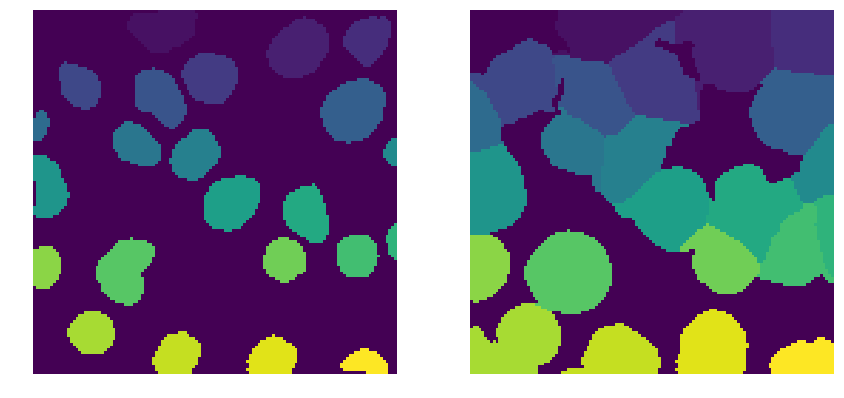

In [65]:
display_images([img_seg_nucl, img_seg_cell], size=30)

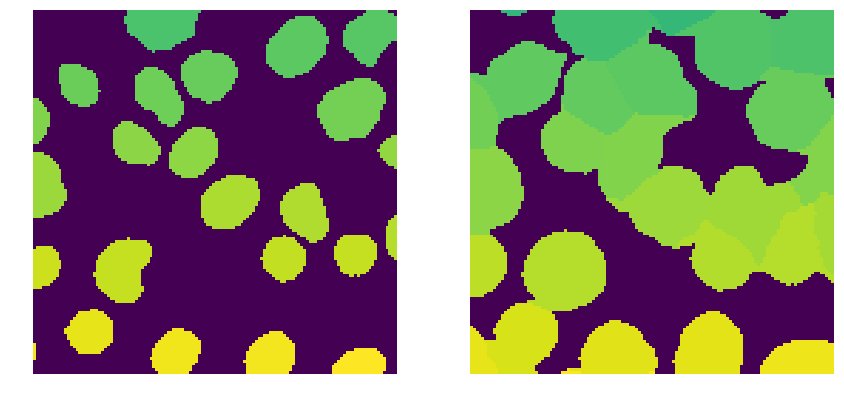

In [66]:
img_val_nucl = sk_io.imread(osp.join(val_dir, 'nuclei.tif'))
img_val_cell = sk_io.imread(osp.join(val_dir, 'cells.tif'))
display_images([img_val_nucl, img_val_cell], size=30)

In [67]:
def iou(im1, im2):
    return ((im1 > 0) & (im2 > 0)).sum() / ((im1 > 0) | (im2 > 0)).sum()

In [68]:
iou(img_seg_nucl, img_val_nucl)

0.8684260489842415

In [69]:
iou(img_seg_cell, img_val_cell)

0.9213443910955914

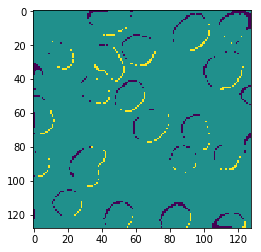

In [70]:
plt.imshow((img_seg_nuc > 0).astype(int) - (img_val_nuc > 0).astype(int))

In [71]:
img_path = osp.join(out_dir, ck_io.get_montage_image_path(ireg=0, name='best_z_segm'))
img_montage = ck_io.read_tile(img_path)
img.shape, img.dtype, img_montage.shape, img_montage.dtype

((1, 1, 8, 128, 128), dtype('uint16'), (1, 1, 8, 128, 128), dtype('uint16'))

In [53]:
# display_images(df['image'])